In [3]:
# We will need some packages, this will install them if they are not available
import sys
!{sys.executable} -m pip install numpy python-igraph matplotlib scipy

You should consider upgrading via the 'c:\python38\python.exe -m pip install --upgrade pip' command.


In [4]:
# temporarily use autoload to modify scripts
%load_ext autoreload
%autoreload 2

In [46]:
from plotting import *
from data import base, val1, val2
from models import Ms, Ss, prediction
from helpers import gen_testcase, discretize_pointwise, discretize_intervals
from scipy.optimize import curve_fit
from scipy.stats import poisson, planck, geom, norm, lognorm, binom, truncnorm, weibull_min
import matplotlib.pyplot as plt
import numpy as np
import math
import random

In [6]:
nodes = 2000
edges = 6
testcase = gen_testcase(nodes, edges)

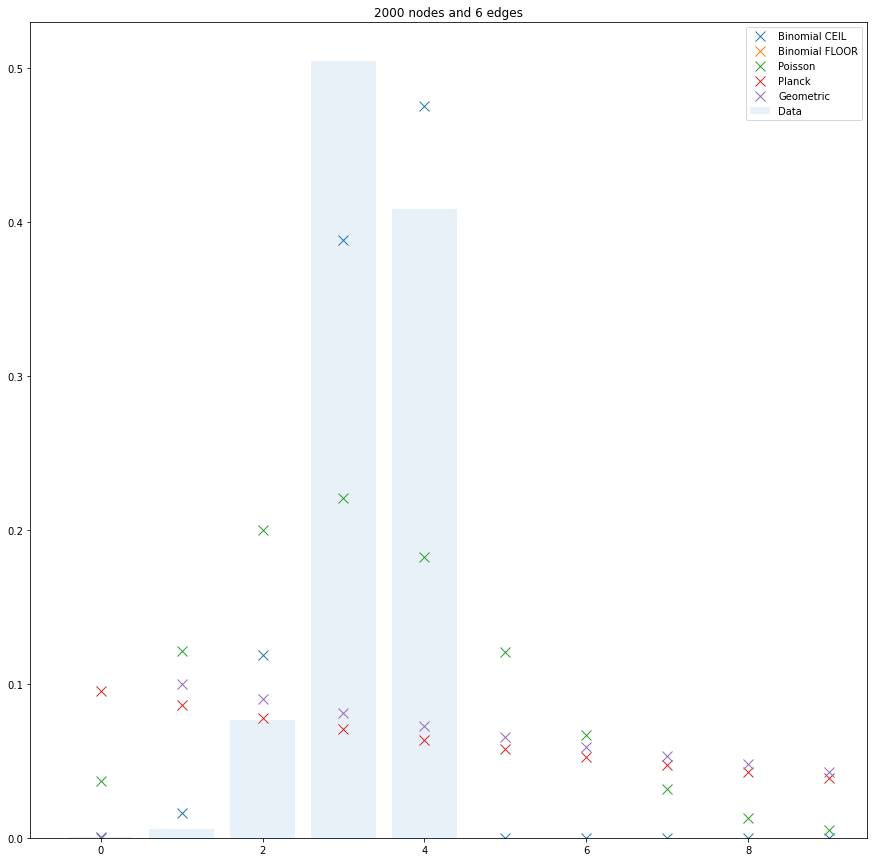

In [76]:
# discrete distributions
plt.figure(figsize=(15,15))

# baseic range
x = testcase["x"]
# extended range
x2 = testcase["x2"]

marksize = 10

# manual maximum likelihood fitting
# as those are not supported directly by scipy
poifit = poisson(sum([a*b for a, b in zip(testcase["freq"], x)]))
plafit = planck(1/sum(x))
geofit = geom(1/sum(x))
# binomial fit
var = np.var(testcase["expandeddata"])
m = np.mean(testcase["expandeddata"])
p = 1 - var/m
n = m/p
binfit = binom(math.ceil(n), m/math.ceil(n))
binfit2 = binom(math.floor(n), m/math.floor(n))

plt.plot(x2, binfit.pmf(x2), 'x', markersize=marksize, label="Binomial CEIL")
plt.plot(x2, binfit2.pmf(x2), 'x', markersize=marksize, label="Binomial FLOOR")

plt.bar(x, testcase["freq"], label="Data", alpha=0.1)

fits = [poifit, plafit, geofit]
names = ["Poisson", "Planck", "Geometric"]

for fit, name in zip(fits, names):
    plt.plot(x2, fit.pmf(x2), 'x', markersize=marksize, label=name)
plt.legend()
plt.title(str(nodes)+" nodes and "+ str(edges)+" edges")
plt.show()

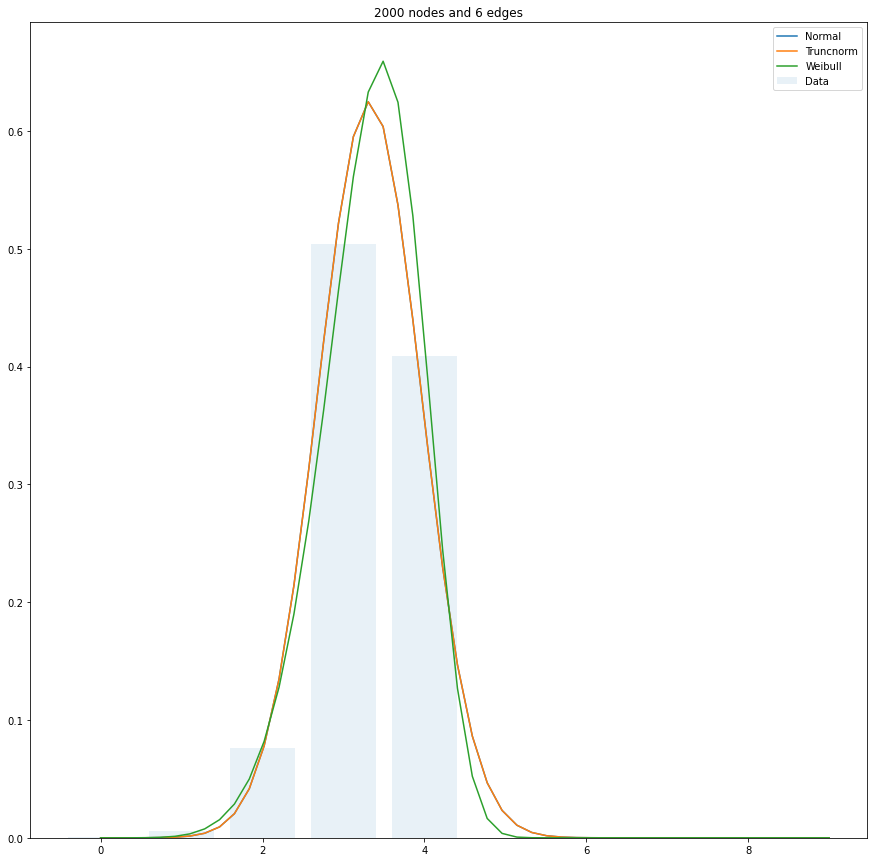

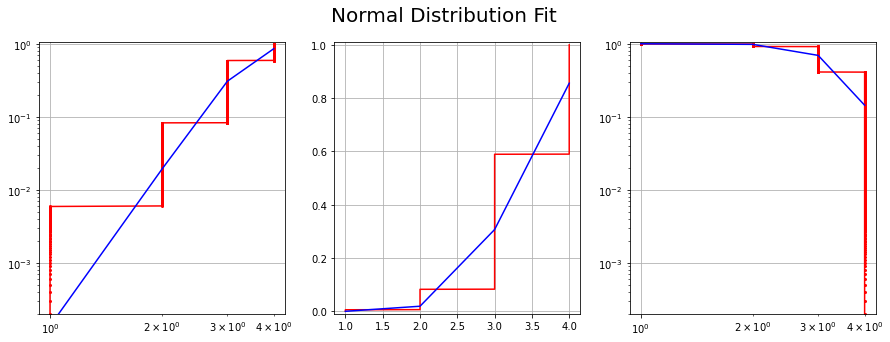

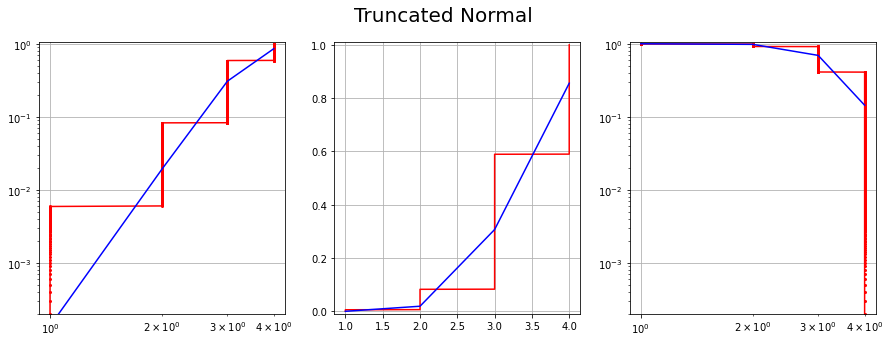

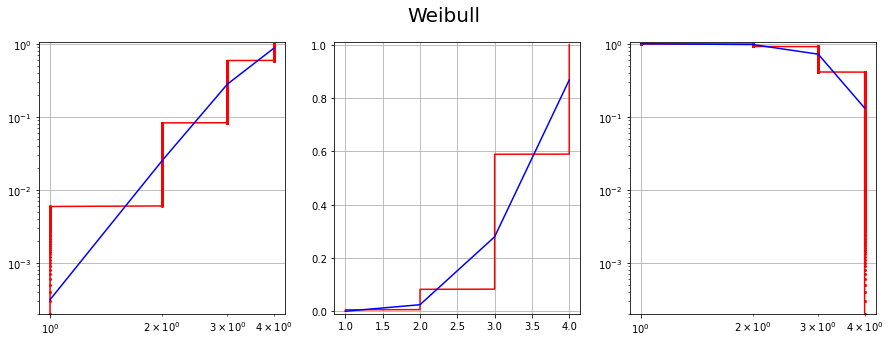

In [74]:
# continuous distributions
plt.figure(figsize=(15,15))
plt.bar(testcase["x"], testcase["freq"], label="Data", alpha=0.1)
x = testcase["x3"]

# fit normal distribution
m, s = norm.fit(testcase["expandeddata"])

# Note that the normal distributino is likely overlapped by the truncated normal distribution
plt.plot(x, norm.pdf(x, m, s), label="Normal")

# fit truncated nromal
i1, i2, i3, i4 = truncnorm.fit(testcase["expandeddata"])
plt.plot(x, truncnorm.pdf(x, (-m)/s, (1000-m)/s, loc=m, scale=s), label="Truncnorm")

# fit weibull
d, e, f = weibull_min.fit(testcase["expandeddata"], floc=0)
plt.plot(x, weibull_min.pdf(x, d, e, f), label="Weibull")

# plot everything together
plt.legend()
plt.title(str(nodes)+" nodes and "+ str(edges)+" edges")
plt.show()

# Detailed comparissons for Normal, Truncated normal and Weibull distribution
plot_and_compare_cdf(testcase["expandeddata"], norm(m, s), "Normal Distribution Fit")
plt.show()
plot_and_compare_cdf(testcase["expandeddata"], truncnorm((-m)/s, (1000-m)/s, loc=m, scale=s), "Truncated Normal")
plt.show()
plot_and_compare_cdf(testcase["expandeddata"], weibull_min(d, e, f), "Weibull")
plt.show()

In [15]:
base.keys()

dict_keys(['nodes', 'edges', 'mu_min', 'mu_means', 'mu_max', 'si_min', 'si_means', 'si_max', 'unique_nodes'])

In [14]:
# ranges for data
ks = range(min(base["edges"]),max(base["edges"])+2,2)
ns = base["unique_nodes"]

# numpy space for functions
Ks = np.linspace(min(base["edges"]),max(base["edges"]))
Ns = np.linspace(min(ns),max(ns))

# grid for 3D presentation
NsMG, KsMG = np.meshgrid(Ns, Ks)

Text(0.5, 0, '# Edges')

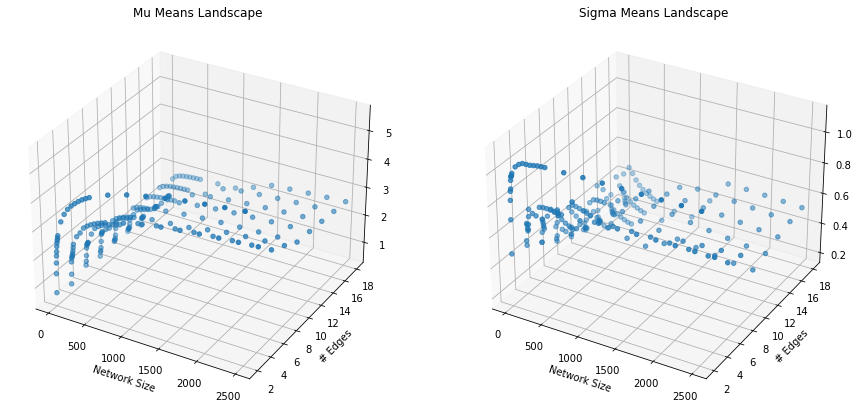

In [70]:
dataset = base
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(121, projection='3d')
ax.set_title("Mu Means Landscape")
ax.scatter(dataset["nodes"],dataset["edges"], dataset["mu_means"])
ax.set_xlabel("Network Size")
ax.set_ylabel("# Edges")
ax = fig.add_subplot(122, projection='3d')
ax.set_title("Sigma Means Landscape")
ax.scatter(dataset["nodes"],dataset["edges"], dataset["si_means"])
ax.set_xlabel("Network Size")
ax.set_ylabel("# Edges")

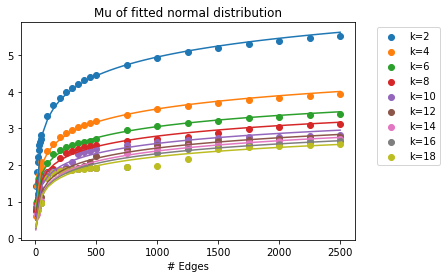

In [43]:
# Behaviour of Mu based on variable edge count
# Estimated behaviour is proportional to log(n)

def logx(x, a, b, c):
    return a*np.log(x*b)+c
Ns = np.linspace(min(base["unique_nodes"]),max(base["unique_nodes"]))

for k in range(min(base["edges"]),max(base["edges"])+2,2): # Plotting all: base["unique_nodes"]
    # Data
    ks = [i for i,x in enumerate(base["edges"]) if x == k]
    ns = [base["nodes"][i] for i in ks]
    mus = [base["mu_means"][i] for i in ks]
    plt.scatter(ns, mus, label=f"k={k}")
    # Fit
    for i in range(20):
        try:
            # for some parameters there are convergence problems
            # but some additoinal attemps finds a solution usually
            fit = curve_fit(logx, ns, mus, bounds=([np.NINF, 0, np.NINF], [np.Inf,np.Inf, np.Inf]))[0]
            break
        except (RuntimeError,np.linalg.LinAlgError):
            continue
    curve = lambda x: logx(x, fit[0], fit[1], fit[2])
    plt.plot(Ns, curve(Ns))
plt.xlabel("# Edges")
plt.title("Mu of fitted normal distribution")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

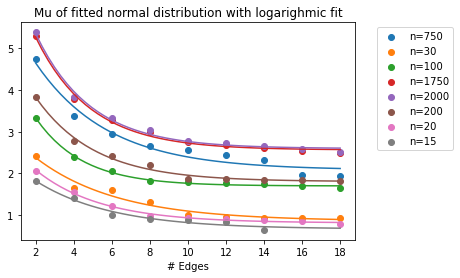

In [44]:
# Behaviour of Mu based on variable edge count
# Estimated behaviour is proportional to 1/exp(k)

def expx(x, a, b, c):
    return c+(a/np.exp(b*x))
Ks = np.linspace(min(base["edges"]),max(base["edges"]))

for n in random.sample(base["unique_nodes"], 8): # Plotting all: base["unique_nodes"]
    # Data
    ns = [i for i,x in enumerate(base["nodes"]) if x == n]
    ks = [base["edges"][i] for i in ns]
    mus = [base["mu_means"][i] for i in ns]
    plt.scatter(ks, mus, label=f"n={n}")
    # Fit
    if len(mus) < 4:
        # not enough data
        continue
    fit = curve_fit(expx, ks, mus)[0]
    curve = lambda x: expx(x, fit[0], fit[1], fit[2])
    plt.plot(Ks, curve(Ks))
plt.xlabel("# Edges")
plt.title("Mu of fitted normal distribution with logarighmic fit")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

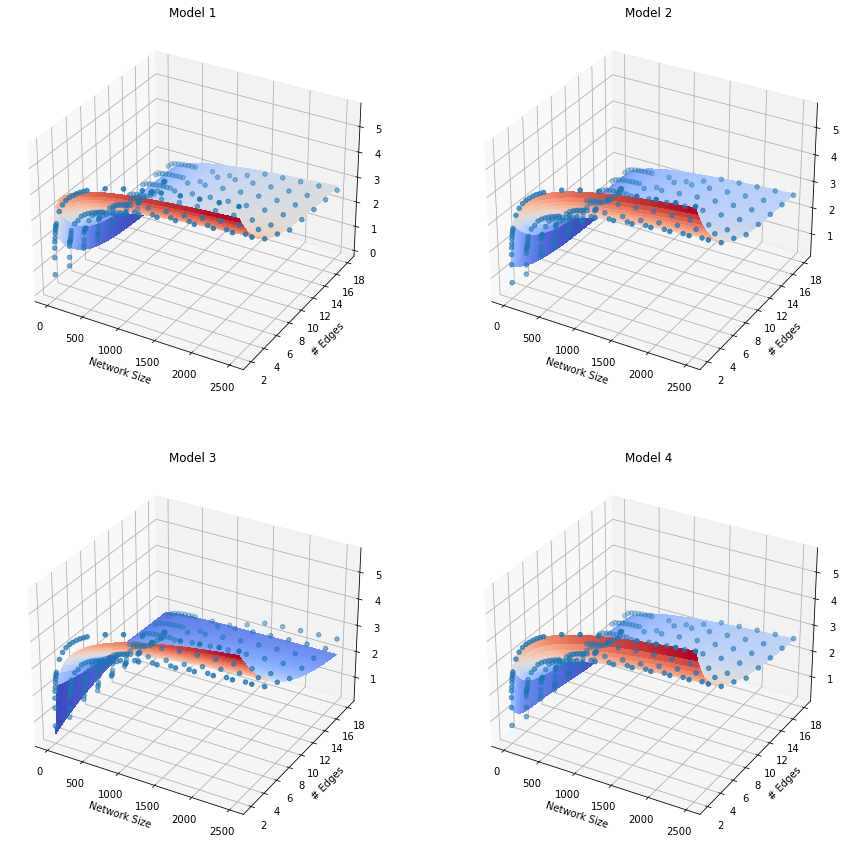

In [66]:
# Visual Model fits?
titles = ["Model 1", "Model 2", "Model 3", "Model 4"]
plot_3d_fit(base, Ms, titles)

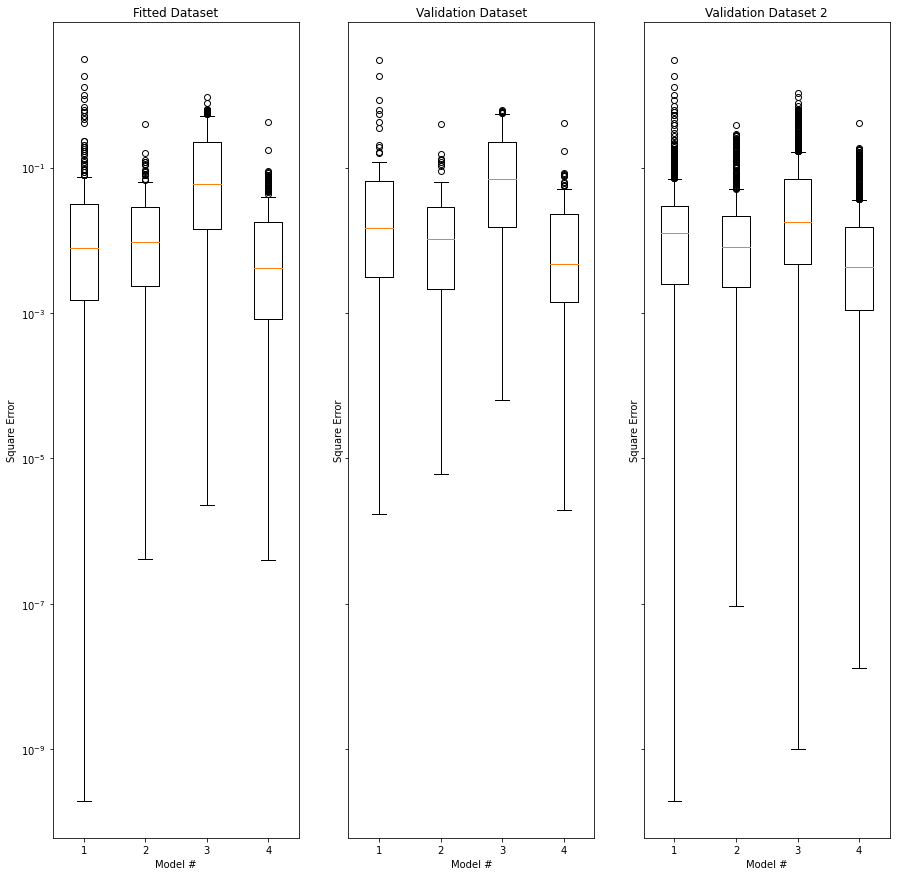

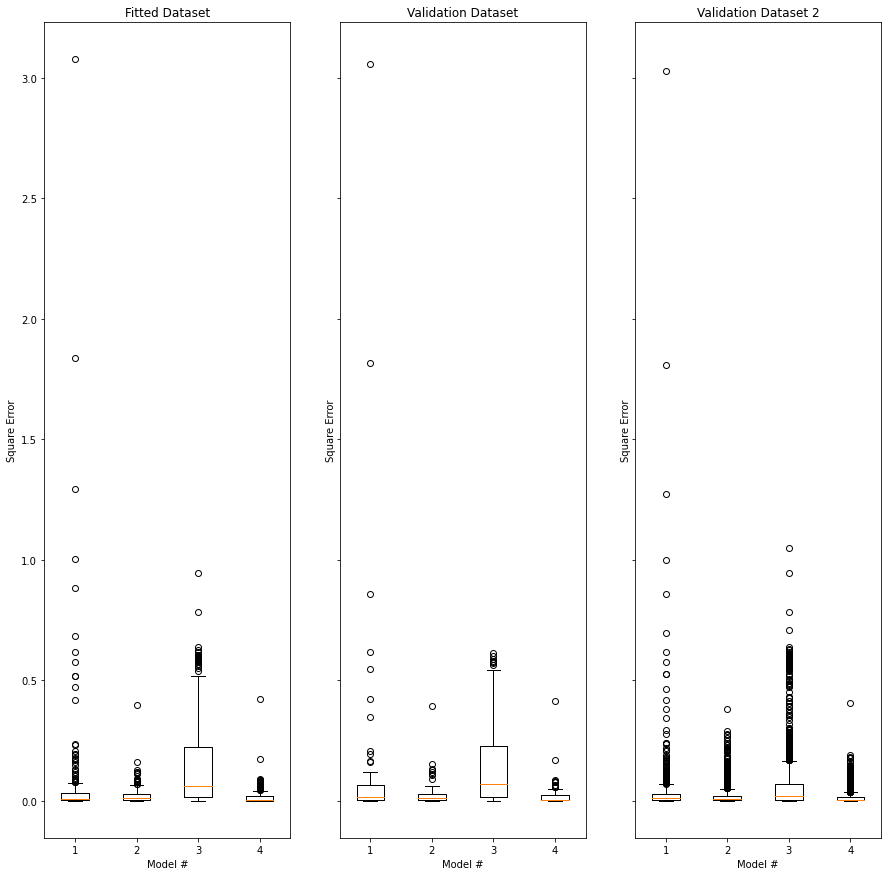

In [60]:
# Logscale version to emphasis lower end of the error
fig = fit_errors(["Fitted Dataset", "Validation Dataset", "Validation Dataset 2"], [base, val1, val2], Ms, "Model #", "Square Error")
# Linear version to emphasis upper end of the error
fig = fit_errors(["Fitted Dataset", "Validation Dataset", "Validation Dataset 2"], [base, val1, val2], Ms, "Model #", "Square Error", False)

AttributeError: 'PathCollection' object has no property 'filled'

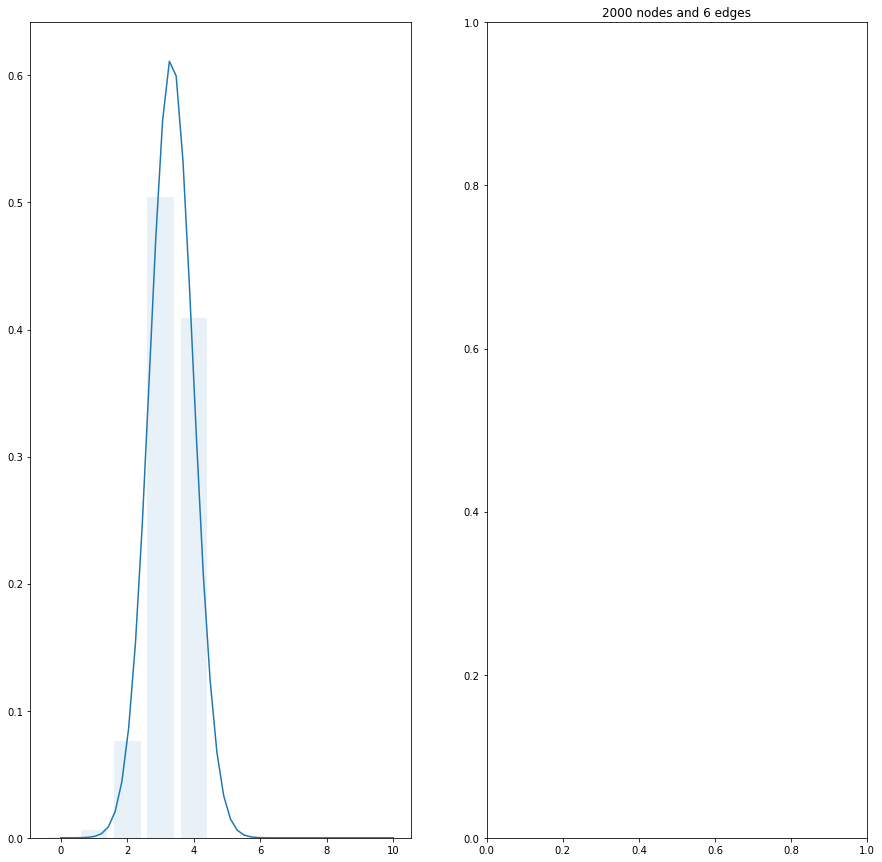

In [86]:
# combined
# prediction based on 
#  * model 4 for mu
#  * model 1 for si
mu, si = prediction(nodes, edges)
# discretization plot of the data, prediction and discretization of the prediction
#  * Re-normalised Pointwise discretization
#  * Intervals around the points: (-inf, 0) for point 0, (0, 1) for 1, etc.
#  * Intervals around the points: (-inf, 0.5) for point 0, (0.5, 1.5) for 1, etc.
# Discretization threshold for ending the discretization is chosen as 0.01
discretization(testcase["freq"], mu, si, nodes, edges)